# RL Assignment 3 : Problem 1 - MountainCar

Name : Ahmik Virani <br>
Roll Number : ES22BTECH11001

In [2]:
import gymnasium as gym
import ale_py
import cv2
import numpy as np
import pygame
import random
from collections import deque
gym.register_envs(ale_py)
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
import matplotlib.pyplot as plt

/opt/anaconda3/envs/gympygame/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


### Q1 (a)

In [3]:
# An agent which takes random actions at each state
def run_random_agent(env, render):
    # We keep track of the reward
    total_reward = 0
    
    # A variable which keeps track of weather the episode is over or not
    done = False
    while not done:
        # Take a random action
        action = env.action_space.sample()
        next_observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        if(render):
            env.render()
        total_reward += reward
    
    # Return the reward for this episode
    return total_reward

# A function which loads the environment
# Prints the necessary points asked in the question
# And runs the random agent
def load_and_test_env(env_name, n_episodes=5, render=False):
    print(f"Loading environment: {env_name}")
    if(render):
        env = gym.make(env_name, render_mode="human")
    else:
        env = gym.make(env_name)

    state_space = env.observation_space
    action_space = env.action_space
    print()
    print("State Space: ", state_space)
    print("Size of State Space", state_space.shape[0])
    print()
    print("Action Space: ", action_space)
    print("Size of Action space: ", action_space.n)
    print()

    for episode in range(n_episodes):
        observation, info = env.reset()
        reward = run_random_agent(env, render)
        print(f"Episode #{episode+1}: reward = {reward}")


In [4]:
load_and_test_env("MountainCar-v0")

Loading environment: MountainCar-v0

State Space:  Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Size of State Space 2

Action Space:  Discrete(3)
Size of Action space:  3

Episode #1: reward = -200.0
Episode #2: reward = -200.0
Episode #3: reward = -200.0
Episode #4: reward = -200.0
Episode #5: reward = -200.0


## Q1 (b)

The core logic of building this architecture is taken from Lecture 13 of class notes

In [5]:
# Implementing a FIFO replay buffer
class replay_buffer():
    # We will define the size of the replay buffer
    def __init__(self, size):

        # By size, I mean the number of samples (s, a, r, s') it can hold
        self.samples = deque(maxlen=size)
    
    # Adding a transition
    # Note that since this is a deque of fixed size, it will automatically pop the first entry is more entries than size are added
    def add_sample(self, sample):
        self.samples.append(sample)
    
    # A function which returns a random batch from the Replay Buffer
    def pick_random(self, batch_size):
        return random.sample(self.samples, batch_size)

    # A function which returns the current size of the replay buffer
    def __len__(self):
        return len(self.samples)

In [6]:
# Mountain Car network

class MountainCar_Network(nn.Module):
    def __init__(self, num_states, num_actions, hidden_dim=64):

        super(MountainCar_Network, self).__init__()

        # A simple feed forward neural network with 2 hidden layers 
        # Relu Activation
        self.fc1 = nn.Linear(num_states, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, num_actions)
        self.apply(self.weights_init)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)
    
    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            # Use output layer size check to identify it
            if m.out_features == self.output.out_features:
                nn.init.uniform_(m.weight, -1e-3, 1e-3)
            else:
                nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    def select_epsilon_greedy_action(self, state, action_space, epsilon=0.1, device='cpu'):
        # Take an epsilon greedy action
        if torch.rand(1).item() < epsilon:
            return action_space.sample()
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = self(state_tensor)
            return torch.argmax(q_values).item()

    def select_greedy_action(self, state, device='cpu'):
        # Take an  greedy action
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self(state_tensor)
        return torch.argmax(q_values).item()

In [7]:
env = gym.make("MountainCar-v0")
num_actions = env.action_space.n
num_states = env.observation_space.shape[0]
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

q_MountainCar = MountainCar_Network(num_states, num_actions)
q_MountainCar = q_MountainCar
summary(q_MountainCar, input_size=(num_states,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             192
            Linear-2                   [-1, 64]           4,160
            Linear-3                    [-1, 3]             195
Total params: 4,547
Trainable params: 4,547
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [8]:
# A helper function to plot the learning curves
# Training curves
def plot_rewards(rewards, y_label, title, label, episode_count = None, window=50, ma = False):
    plt.figure(figsize=(10,5))

    if episode_count is None:
        x_axis = np.arange(len(rewards))
    else:
        x_axis = episode_count

    plt.plot(x_axis, rewards, label=label, alpha=0.4)
    if(ma):
        smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
        plt.plot(smoothed, label=f'{window}-episode Moving Avg', linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

Episode 100: Avg Test Reward = -200.00, Epsilon = 0.968
Episode 200: Avg Test Reward = -200.00, Epsilon = 0.937
Episode 300: Avg Test Reward = -200.00, Epsilon = 0.905
Episode 400: Avg Test Reward = -200.00, Epsilon = 0.873
Episode 500: Avg Test Reward = -200.00, Epsilon = 0.842
Episode 600: Avg Test Reward = -200.00, Epsilon = 0.810
Episode 700: Avg Test Reward = -196.60, Epsilon = 0.778
Episode 800: Avg Test Reward = -127.10, Epsilon = 0.747
Episode 900: Avg Test Reward = -120.60, Epsilon = 0.715
Episode 1000: Avg Test Reward = -142.10, Epsilon = 0.683
Episode 1100: Avg Test Reward = -117.30, Epsilon = 0.652
Episode 1200: Avg Test Reward = -122.00, Epsilon = 0.620
Episode 1300: Avg Test Reward = -118.60, Epsilon = 0.589
Episode 1400: Avg Test Reward = -125.50, Epsilon = 0.558
Episode 1500: Avg Test Reward = -116.60, Epsilon = 0.527
Episode 1600: Avg Test Reward = -165.20, Epsilon = 0.497
Episode 1700: Avg Test Reward = -121.20, Epsilon = 0.467
Episode 1800: Avg Test Reward = -113.10,

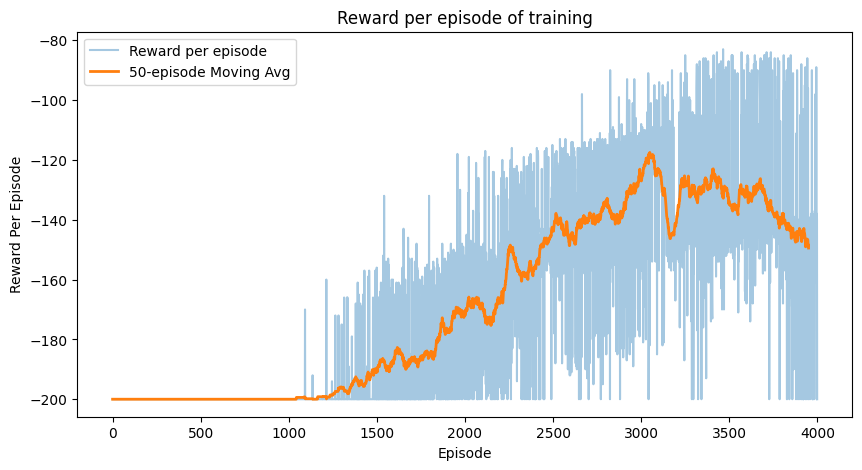

In [9]:
env = gym.make("MountainCar-v0")
gamma = 0.99 
batch_size = 128
N = 50000
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
learning_rate = 5e-4
epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay_steps = 600000

TAU = 0.99

# Steps in order from Lecture 13 of class notes

# 1: Intialize replay memory D to capacity N
D = replay_buffer(N)

# 2: Initialize action value function Q with parameters ϕ
Q = MountainCar_Network(num_states, num_actions, hidden_dim=64).to(device)

# 3: Initialize target action value function Q' with parameters ϕ′
Q_target = MountainCar_Network(num_states, num_actions, hidden_dim=64).to(device)

# Copy initial weights
Q_target.load_state_dict(Q.state_dict())

'''
4: for episodes = 1 to M do
5: Initialize start state s1
6: for steps t= 1 to T do
7: Select action at using ϵ-greedy policy
8: Execute action at and store transition (st,at,rt,st+1) in D
9: Sample random minibatch (size B) of transitions from D
10: for b = 1 to B do
11: Calculate targets for each transitions (Bellman backup or reward)
12: end for
13: Perform a gradient descent step on (yi-Qϕ(st,at))2 w.r.t ϕ
14: Every C steps set Q= Q
15: end for
16: end for
'''

optimizer = optim.RMSprop(Q.parameters(), lr=learning_rate, alpha=0.95, eps=0.01)

reward_per_episode = []
test_reward_per_episode = []

def normalize_state(state):
    low = np.array(env.observation_space.low)
    high = np.array(env.observation_space.high)
    return (state - low) / (high - low)

# Pre-fill buffer
state, _ = env.reset()
for _ in range(1000):
    a = env.action_space.sample()
    next_state, reward, terminated, truncated, info = env.step(a)
    done = terminated or truncated

    # Ensure to normaize before passing to the replay buffer
    D.add_sample((normalize_state(state), a, reward, normalize_state(next_state), done))
    if done:
        state, _ = env.reset()
    else:
        state = next_state

# Specify the number of training episodes
M = 4000
steps = 0
for episodes in range(1, M+1):
    state, _ = env.reset()
    done = False

    total_reward = 0
    total_true_reward = 0
    while(not done):
        steps += 1

        # Select epsilon greedy action
        decay_ratio = steps / epsilon_decay_steps
        epsilon = epsilon_start - (epsilon_start - epsilon_end) * decay_ratio
        epsilon = max(epsilon_end, epsilon) # Ensure it doesn't drop below the minimum
        a = Q.select_epsilon_greedy_action(normalize_state(state), env.action_space, epsilon = epsilon, device=device)

        # Then we execute the action
        next_state, reward, terminated, truncated, info = env.step(a)
        done = terminated or truncated
        
        position, velocity = next_state
        r = reward 
        total_true_reward += r

        # Give reward based on position so the higher it goes the more momentum it gets
        r += abs(position + 0.5)

        # Give a big reward for reaching the destination
        if position >= 0.5:
            r += 100.0

        total_reward += r

        # We store the transition in replay buffer
        D.add_sample((normalize_state(state),a,r,normalize_state(next_state), done))

        state = next_state

        if done:
            break

        # We sample a minibatch
        if len(D) > batch_size:
            B = D.pick_random(batch_size)
            states = torch.tensor(np.array([t[0] for t in B], dtype=np.float32)).to(device)
            next_states = torch.tensor(np.array([t[3] for t in B], dtype=np.float32)).to(device)
            actions = torch.tensor(np.array([t[1] for t in B], dtype=np.int64)).to(device)
            rewards = torch.tensor(np.array([t[2] for t in B], dtype=np.float32)).to(device)
            dones = torch.tensor(np.array([t[4] for t in B], dtype=np.float32)).to(device)


            with torch.no_grad():
                # 1. Use the main network to select the greedy action
                best_actions = Q(next_states).argmax(1)
                
                # 2. Use the target network to get the Q value
                q_target_next = Q_target(next_states).gather(1, best_actions.unsqueeze(1)).squeeze(1)
                
                # 3. Compute the Bellman target
                q_target = rewards + gamma * q_target_next * (1 - dones)

            q_values = Q(states)
            q_s_a = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

            # Use Huber loss
            loss = F.smooth_l1_loss(q_s_a, q_target)

            # gradient descent step
            optimizer.zero_grad()
            loss.backward()
            # Clip the gradients for smooth gradient descent and prevent exploding gradient problem
            torch.nn.utils.clip_grad_norm_(Q.parameters(), 10.0)
            optimizer.step()

            # Polyak Averaging
            with torch.no_grad():
                for param, target_param in zip(Q.parameters(), Q_target.parameters()):
                    target_param.data.mul_(TAU)
                    target_param.data.add_((1-TAU) * param.data)

    reward_per_episode.append(total_true_reward)  

    # After every 100 episodes, run testing to see how it is performing
    if episodes % 100 == 0:
        test_rewards = []
        for _ in range(10):
            state, _ = env.reset()
            done = False
            total_r = 0
            while not done:
                a = Q.select_greedy_action(normalize_state(state), device=device)
                state, r, terminated, truncated, _ = env.step(a)
                done = terminated or truncated
                total_r += r
            test_rewards.append(total_r)
        print(f"Episode {episodes}: Avg Test Reward = {np.mean(test_rewards):.2f}, Epsilon = {epsilon:.3f}")
        test_reward_per_episode.append(np.mean(test_rewards))
    
plot_rewards(reward_per_episode, 'Reward Per Episode', 'Reward per episode of training', 'Reward per episode' , ma = True)

In [10]:
print("Maximum Reward: ", max(reward_per_episode))

Maximum Reward:  -83.0


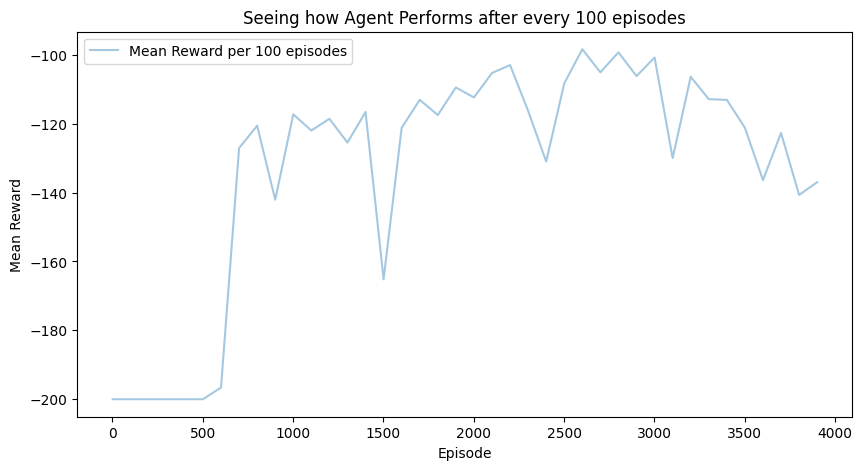

In [11]:
episodes = [i for i in range(1, M+1, 100)]
plot_rewards(test_reward_per_episode,'Mean Reward', 'Seeing how Agent Performs after every 100 episodes', 'Mean Reward per 100 episodes' , episodes)

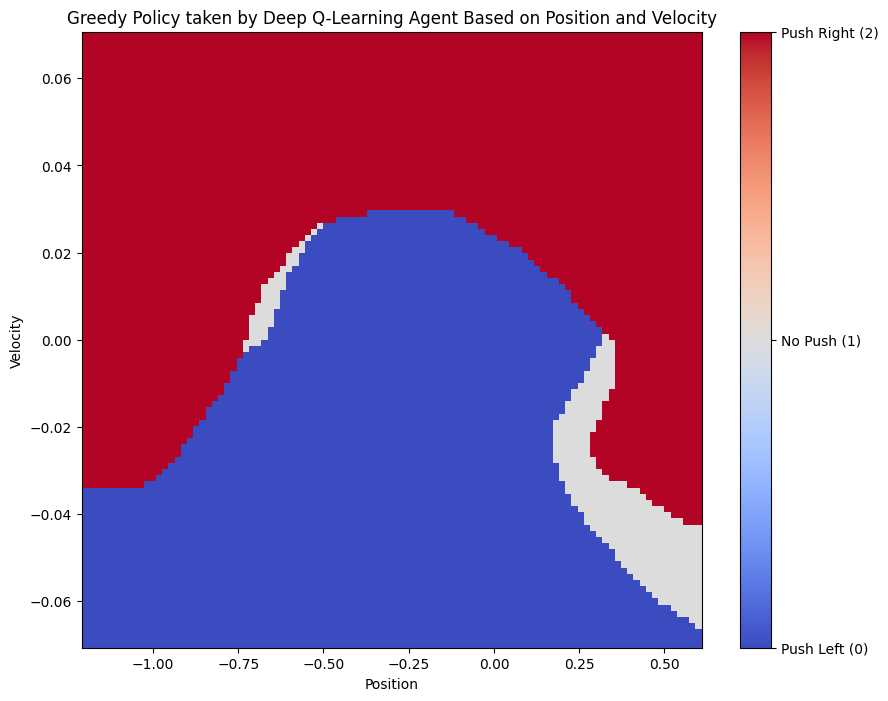

In [12]:
Q.eval()

# Now let us try to create how the DQN Agent would take an action depending on the position and velocity
# Let us divide it into 100 uniformly spread out points
pos_vals = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 100)
vel_vals = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 100)

# We then create a grid
P, V = np.meshgrid(pos_vals, vel_vals)

states_batch = np.stack([P.ravel(), V.ravel()], axis=1)

norm_states_batch = normalize_state(states_batch)

# We then make tensor to pass to the Q-Learning Agent
states_tensor = torch.tensor(norm_states_batch, dtype=torch.float32).to(device)

# Take greedy action
with torch.no_grad():
    q_values = Q(states_tensor)
    actions = torch.argmax(q_values, dim=1).cpu().numpy()

action_grid = actions.reshape(P.shape)

plt.figure(figsize=(10, 8))

plt.pcolormesh(P, V, action_grid, cmap='coolwarm', shading='auto')

plt.xlabel("Position")
plt.ylabel("Velocity")
plt.title("Greedy Policy taken by Deep Q-Learning Agent Based on Position and Velocity")

# We then color code
cbar = plt.colorbar(ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['Push Left (0)', 'No Push (1)', 'Push Right (2)'])

plt.show()

## Q1 (c)

In [13]:
env = gym.make("MountainCar-v0")
gamma = 0.99 
batch_size = 128
N = 50000
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
learning_rate = 5e-4
epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay_steps = 600000

combined_reward_per_episode = []
combined_test_reward_per_episode = []

TAU = 0.99
for hidden_dim in [32, 64, 128]:
    # Steps in order from Lecture 13 of class notes

    # 1: Intialize replay memory D to capacity N
    D = replay_buffer(N)

    # 2: Initialize action value function Q with parameters ϕ
    Q = MountainCar_Network(num_states, num_actions, hidden_dim=hidden_dim).to(device)

    # 3: Initialize target action value function Q' with parameters ϕ′
    Q_target = MountainCar_Network(num_states, num_actions, hidden_dim=hidden_dim).to(device)

    # Copy initial weights
    Q_target.load_state_dict(Q.state_dict())

    '''
    4: for episodes = 1 to M do
    5: Initialize start state s1
    6: for steps t= 1 to T do
    7: Select action at using ϵ-greedy policy
    8: Execute action at and store transition (st,at,rt,st+1) in D
    9: Sample random minibatch (size B) of transitions from D
    10: for b = 1 to B do
    11: Calculate targets for each transitions (Bellman backup or reward)
    12: end for
    13: Perform a gradient descent step on (yi-Qϕ(st,at))2 w.r.t ϕ
    14: Every C steps set Q= Q
    15: end for
    16: end for
    '''

    optimizer = optim.RMSprop(Q.parameters(), lr=learning_rate, alpha=0.95, eps=0.01)

    reward_per_episode = []
    test_reward_per_episode = []

    def normalize_state(state):
        low = np.array(env.observation_space.low)
        high = np.array(env.observation_space.high)
        return (state - low) / (high - low)

    # Pre-fill buffer
    state, _ = env.reset()
    for _ in range(1000):
        a = env.action_space.sample()
        next_state, reward, terminated, truncated, info = env.step(a)
        done = terminated or truncated

        # Ensure to normaize before passing to the replay buffer
        D.add_sample((normalize_state(state), a, reward, normalize_state(next_state), done))
        if done:
            state, _ = env.reset()
        else:
            state = next_state

    # Number of training episodes
    M = 4000
    steps = 0
    for episodes in range(1, M+1):
        state, _ = env.reset()
        done = False

        total_reward = 0
        total_true_reward = 0
        while(not done):
            steps += 1

            # Select epsilon greedy action
            decay_ratio = steps / epsilon_decay_steps
            epsilon = epsilon_start - (epsilon_start - epsilon_end) * decay_ratio
            epsilon = max(epsilon_end, epsilon) # Ensure it doesn't drop below the minimum
            a = Q.select_epsilon_greedy_action(normalize_state(state), env.action_space, epsilon = epsilon, device=device)

            # Then we execute the action
            next_state, reward, terminated, truncated, info = env.step(a)
            done = terminated or truncated
            
            position, velocity = next_state
            r = reward 
            total_true_reward += r

            # Give reward based on position so the higher it goes the more momentum it gets
            r += abs(position + 0.5)

            # Give a big reward for reaching the destination
            if position >= 0.5:
                r += 100.0

            total_reward += r

            # We store the transition in replay buffer
            D.add_sample((normalize_state(state),a,r,normalize_state(next_state), done))

            state = next_state

            if done:
                break

            # We sample a minibatch
            if len(D) > batch_size:
                B = D.pick_random(batch_size)
                states = torch.tensor(np.array([t[0] for t in B], dtype=np.float32)).to(device)
                next_states = torch.tensor(np.array([t[3] for t in B], dtype=np.float32)).to(device)
                actions = torch.tensor(np.array([t[1] for t in B], dtype=np.int64)).to(device)
                rewards = torch.tensor(np.array([t[2] for t in B], dtype=np.float32)).to(device)
                dones = torch.tensor(np.array([t[4] for t in B], dtype=np.float32)).to(device)


                with torch.no_grad():
                    # 1. Use the main network to select the greedy action
                    best_actions = Q(next_states).argmax(1)
                    
                    # 2. Use the target network to get the Q value
                    q_target_next = Q_target(next_states).gather(1, best_actions.unsqueeze(1)).squeeze(1)
                    
                    # 3. Compute the Bellman target
                    q_target = rewards + gamma * q_target_next * (1 - dones)

                q_values = Q(states)
                q_s_a = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

                # Use Huber loss
                loss = F.smooth_l1_loss(q_s_a, q_target)

                # gradient descent step
                optimizer.zero_grad()
                loss.backward()
                # Clip the gradients for smooth gradient descent and prevent exploding gradient problem
                torch.nn.utils.clip_grad_norm_(Q.parameters(), 10.0)
                optimizer.step()

                # Polyak Averaging
                with torch.no_grad():
                    for param, target_param in zip(Q.parameters(), Q_target.parameters()):
                        target_param.data.mul_(TAU)
                        target_param.data.add_((1-TAU) * param.data)

        reward_per_episode.append(total_true_reward)  

        # After every 100 episodes, run testing to see how it is performing
        if episodes % 100 == 0:
            test_rewards = []
            for _ in range(10):
                state, _ = env.reset()
                done = False
                total_r = 0
                while not done:
                    a = Q.select_greedy_action(normalize_state(state), device=device)
                    state, r, terminated, truncated, _ = env.step(a)
                    done = terminated or truncated
                    total_r += r
                test_rewards.append(total_r)
            test_reward_per_episode.append(np.mean(test_rewards))

    combined_reward_per_episode.append(reward_per_episode)
    combined_test_reward_per_episode.append(test_reward_per_episode)

In [14]:
random_reward = []
for i in range(1, M+1):
    # We keep track of the reward
    total_reward = 0
    
    # A variable which keeps track of whether the episode is over or not
    done = False
    
    state, _ = env.reset() 
    
    while not done:
        # Take a random action
        action = env.action_space.sample()
        next_observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        total_reward += reward
    
    random_reward.append(total_reward)

In [15]:
mean_random_reward = []
i = 1
sum = 0
while i <= M:
    sum += random_reward[i-1]
    if i % 100 == 0:
        mean_random_reward.append(sum)
        sum = 0
    i+=1

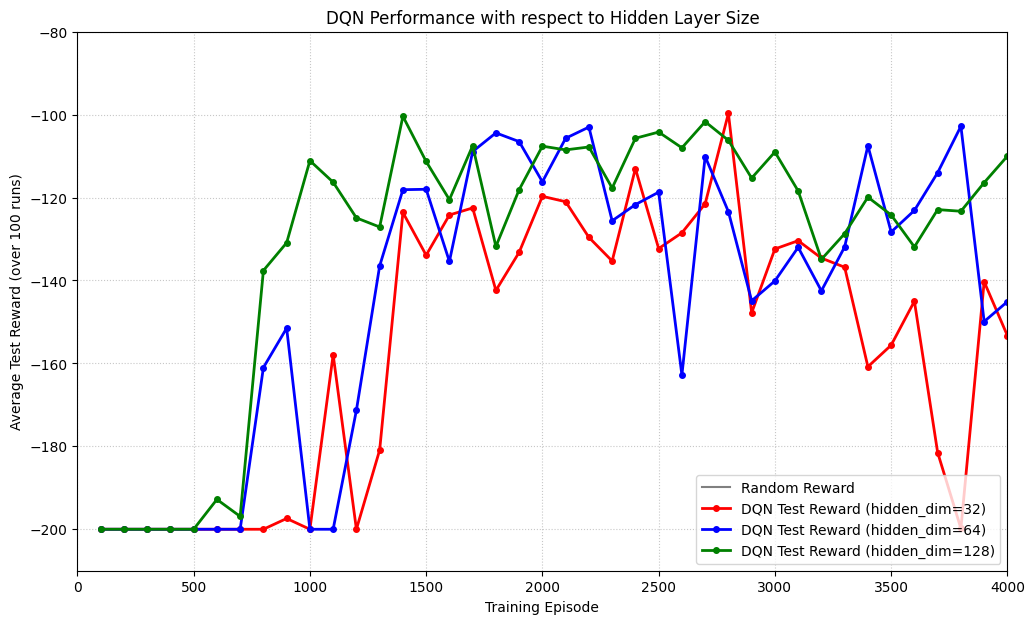

In [18]:
# I am testing on hidden layers of sizes 32, 64, 128
hidden_dims = [32, 64, 128] 

# We have tested after every 100 episodes
test_interval = 100         

# We have trained for a total of 4000 episodes
M = 4000                    

num_test_points = len(combined_test_reward_per_episode[0])
test_episode_axis = (np.arange(num_test_points) + 1) * test_interval

plt.figure(figsize=(12, 7))

# Plot the random reward first
plt.plot(test_episode_axis, mean_random_reward, label="Random Reward", color='gray')

colors = ['red', 'blue', 'green']

# Loop through your 3 test results and plot them
for i, rewards in enumerate(combined_test_reward_per_episode):
    label_text = f"DQN Test Reward (hidden_dim={hidden_dims[i]})"
    plt.plot(test_episode_axis, rewards, label=label_text, color=colors[i], marker='o', markersize=4, linewidth=2)

# 5. Add labels and legend
plt.xlabel('Training Episode')
plt.ylabel('Average Test Reward (over 100 runs)')
plt.title('DQN Performance with respect to Hidden Layer Size')
plt.legend(loc='lower right')
plt.grid(True, linestyle=':', alpha=0.7)

# Set x and y limits for clarity
plt.xlim(0, M)
plt.ylim(-210, -80) # Adjust y-limit as needed, but -210 is a good floor
plt.show()

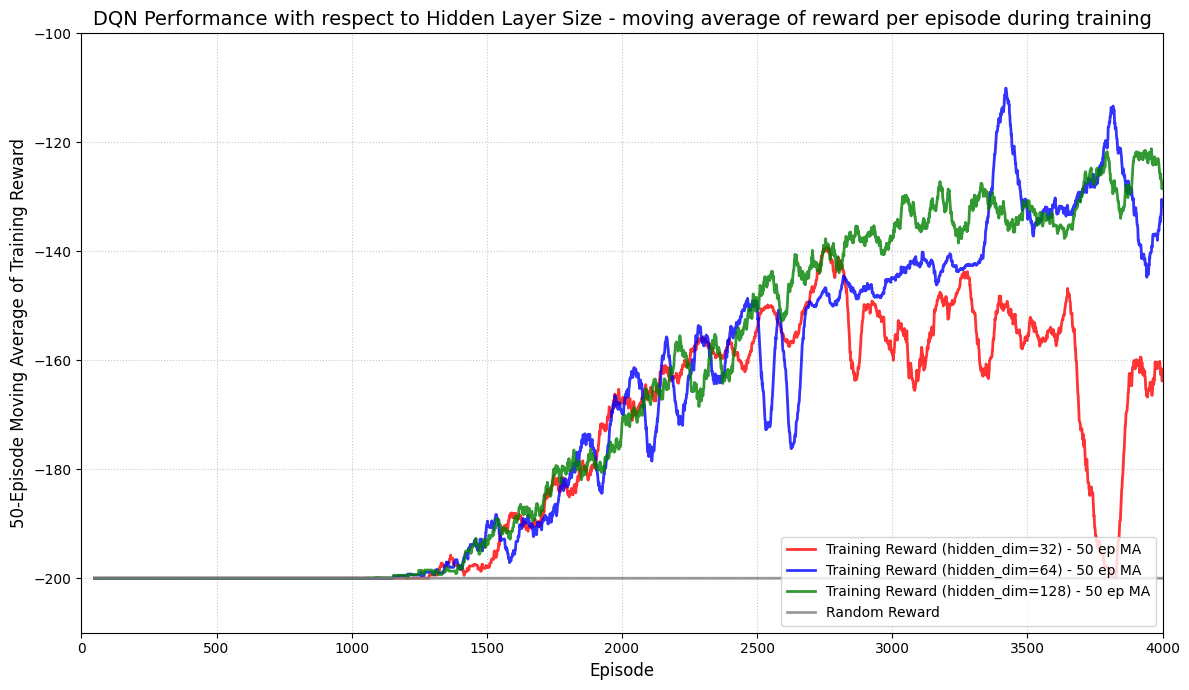

In [20]:
# I am testing on hidden layers of sizes 32, 64, 128
hidden_dims = [32, 64, 128] 

# We have trained for a total of 4000 episodes
M = 4000                    

plt.figure(figsize=(12, 7))

combined_reward_per_episode.append(random_reward)

colors = ['red', 'blue', 'green']

window_size = 50

for i, raw_rewards in enumerate(combined_reward_per_episode):
    if len(raw_rewards) == M:
        # Calculate the moving average
        smoothed_rewards = np.convolve(raw_rewards, np.ones(window_size)/window_size, mode='valid')
        
        # Create the x-axis for the smoothed data
        smoothed_x_axis = np.arange(window_size - 1, M)
        if i < 3:
            label_text = f"Training Reward (hidden_dim={hidden_dims[i]}) - {window_size} ep MA"
            plt.plot(smoothed_x_axis, smoothed_rewards, label=label_text, color=colors[i], alpha=0.8, linewidth=2)
        else:
            label_text = "Random Reward"
            plt.plot(smoothed_x_axis, smoothed_rewards, label=label_text, color='gray', alpha=0.8, linewidth=2)

# 5. Add labels and legend
plt.xlabel('Episode', fontsize=12)
plt.ylabel(f'{window_size}-Episode Moving Average of Training Reward', fontsize=12)
plt.title(f'DQN Performance with respect to Hidden Layer Size - moving average of reward per episode during training', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, linestyle=':', alpha=0.7)
plt.xlim(0, M)
plt.ylim(-210, -100) # Adjust y-limit
plt.tight_layout()
plt.show()